# P4 - 02 - Modelisation notebook

The city of Seattle wants to predict buildings CO2 emissions and energy consumption, using the data available on the construction permit. We can use the two energy benchmarking files in order to create some models for these predictions : https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking

This notebook is only the second part of the work (preprocessing and modeling). For the modeling work, go on the first one.

1. **[Preprocessing](#1)**
    1. [Preprocessing features](#1)
    2. [Preprocessing targets](#1.2)
    3. [Defining preprocessing pipelines](#1.3)
2. **[Model selection](#2)**
    1. [Pipeline and best models selection](#2)
    2. [Effect of cross-validation shuffle parameter on score](#2.2)
    3. [Optimizing models hyperparameters](#2.3)
        1. [Validation curves](#2.3)
        2. [GridSearchCV](#2.3.2)
        3. [Measuring impact of optimization](#2.3.3)
    4. [Impact of EnergyStar Score on models ](#2.4)
3. **[Exploring our final model](#3)**
    1. [Features importances](#3.1)
    2. [Metrics](#3.2)
    3. [Real values VS predicted values](#3.3)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Preprocessing librairies
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# Modeling librairies
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, validation_curve, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from common_functions import *

In [2]:
# Display options 
sns.set_theme()

MAIN_CHART_COLOR = 'darkorange'
OUTPUT_CHART_COLOR = 'lightgreen'
TARGET_COLORS = ['#2498c1', '#075792']
TARGET_SECONDARY_COLORS = ['#CA7C29', '#C20A0A']

In [3]:
data = get_merged_data()

In [4]:
# Setting all the required features/target names in variables for the rest of the notebook
targets = get_targets()
scaling_features = get_scaling_features()
scaling_features_with_energy_star_score = get_scaling_features(with_energy_star_score=True)
encoding_features = get_encoding_features()
drop_nan_features = get_drop_nan_features()

<a name="1"></a>
# 1. Preprocessing
## 1.1 Preprocessing features

In [5]:
data_preprocessing = manage_existing_features(data)

In [6]:
# Setting all int and float features into one
features_to_scale = data_preprocessing.dtypes.where(lambda x: (x == 'int64') | (x == 'float64')).dropna().index.tolist()
features_to_scale.remove('ENERGYSTARScore')

for column in targets:
    features_to_scale.remove(column)

features_to_scale

['BuildingAge',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA']

<AxesSubplot:title={'center':'Quantitative features distributions before preprocessing'}>

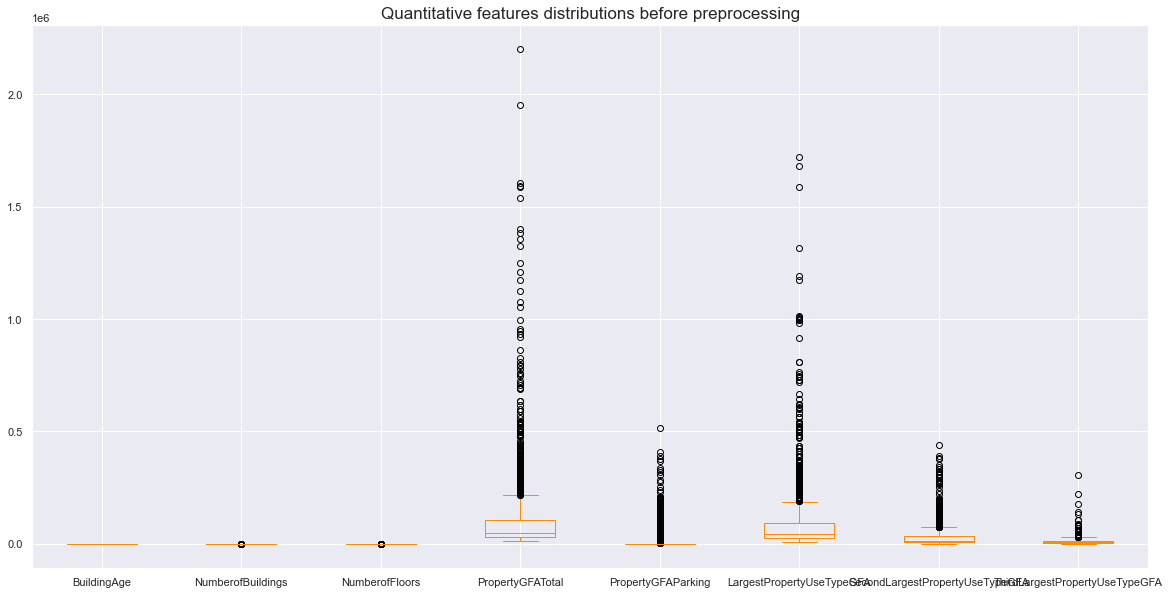

In [7]:
plt.figure(figsize=(20,10))
plt.title("Quantitative features distributions before preprocessing", fontsize=17)
data_preprocessing[scaling_features].boxplot(color=MAIN_CHART_COLOR)

### Scaling quantitative features

array([[<AxesSubplot:title={'center':'BuildingAge'}>,
        <AxesSubplot:title={'center':'NumberofBuildings'}>,
        <AxesSubplot:title={'center':'NumberofFloors'}>],
       [<AxesSubplot:title={'center':'PropertyGFATotal'}>,
        <AxesSubplot:title={'center':'PropertyGFAParking'}>,
        <AxesSubplot:title={'center':'LargestPropertyUseTypeGFA'}>],
       [<AxesSubplot:title={'center':'SecondLargestPropertyUseTypeGFA'}>,
        <AxesSubplot:title={'center':'ThirdLargestPropertyUseTypeGFA'}>,
        <AxesSubplot:>]], dtype=object)

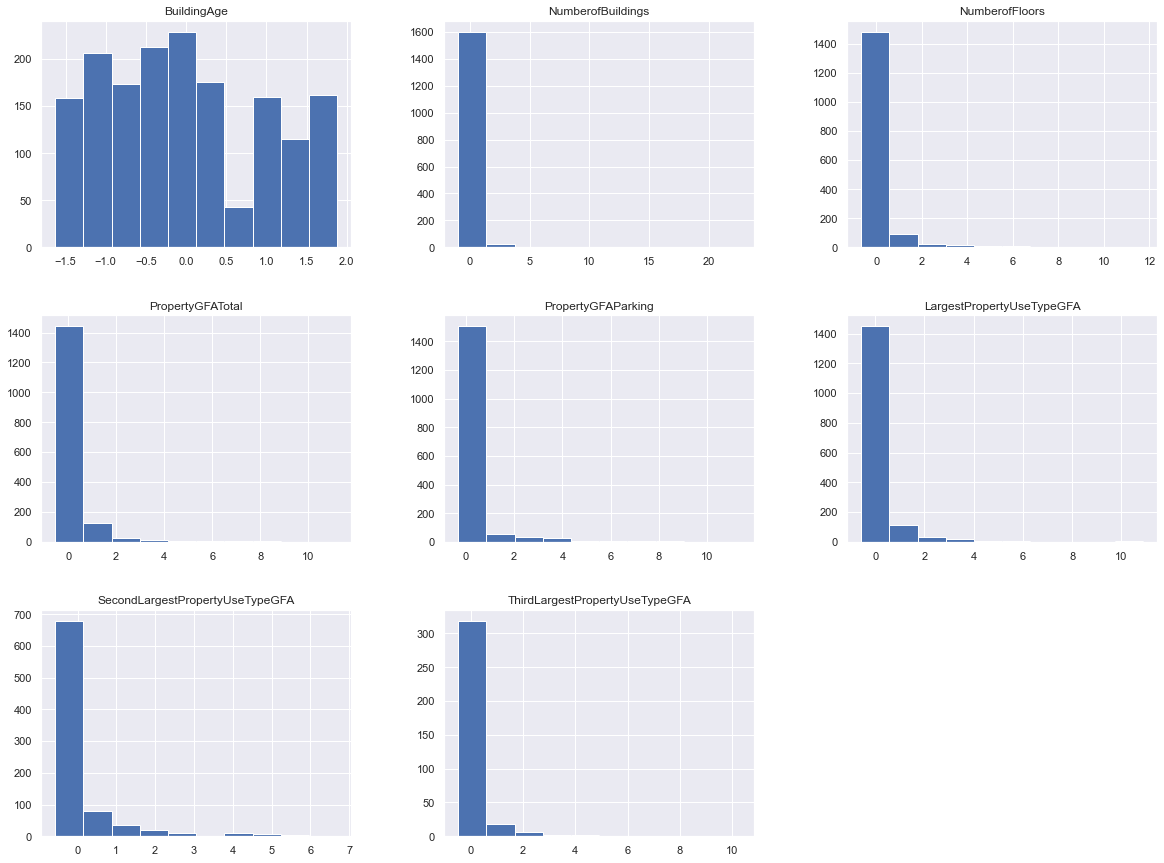

In [8]:
data_test = data_preprocessing.copy()

scaler = StandardScaler()
data_test[scaling_features] = scaler.fit_transform(data_test[scaling_features])

data_test[scaling_features].hist(figsize=(20,15))

<a name="1.2"></a>
## 1.2 Preprocessing targets

In [8]:
def show_targets_distributions(data, targets):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,6), sharex="col", gridspec_kw={"height_ratios": (.15, .85)})

    sns.boxplot(x=data['SiteEnergyUse(kBtu)'], color=TARGET_COLORS[0], ax=axes[0][0])
    sns.histplot(data=data['SiteEnergyUse(kBtu)'], bins=100, color=TARGET_COLORS[0], ax=axes[1][0])
    axes[0][0].set_title('Site Energy Use distribution BEFORE preprocessing', fontsize=16)
    
    sns.boxplot(x=data['TotalGHGEmissions'], color=TARGET_COLORS[1], ax=axes[0][1])
    sns.histplot(data=data['TotalGHGEmissions'], bins=100, color=TARGET_COLORS[1], ax=axes[1][1])
    axes[0][1].set_title('GHG Emissions distribution BEFORE preprocessing', fontsize=16)

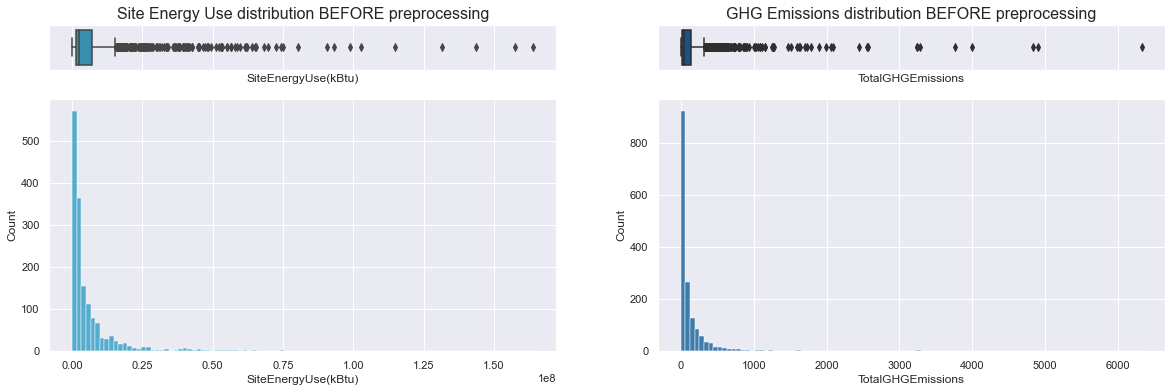

In [9]:
show_targets_distributions(data_preprocessing.copy(), targets)

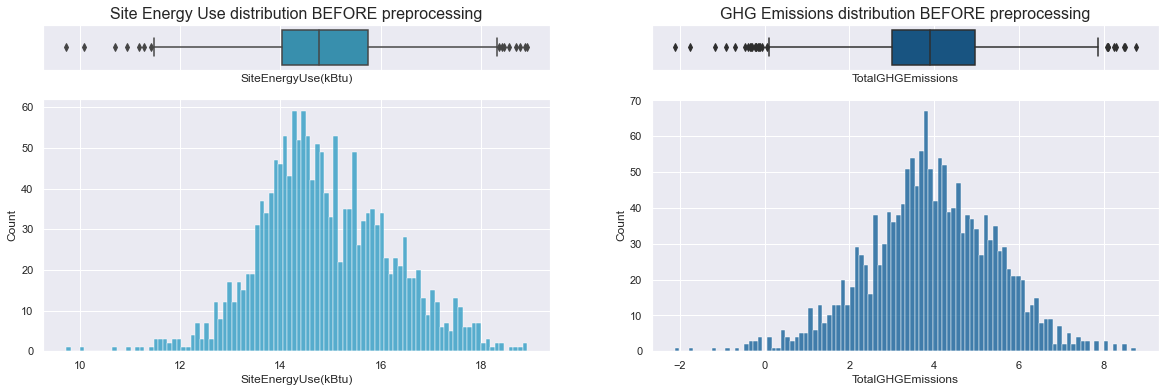

In [10]:
data_target_preprocessed = data_preprocessing.copy()
data_target_preprocessed[targets] = np.log(data_target_preprocessed[targets])
show_targets_distributions(data_target_preprocessed, targets)

<a name="1.3"></a>
## 1.3 Defining preprocessing pipelines

In [17]:
PREPROCESS_PIPELINES = {
    'default': {
        'features': Pipeline(steps=[
            ('features_scaling', ColumnTransformer([
                (
                    'standard_scaler',
                    StandardScaler(),
                    scaling_features
                ),
                (
                    'one_hot_encoding',
                    OneHotEncoder(),
                    encoding_features
                )
            ], remainder='drop'))
        ]),
        'targets': Pipeline(steps=[
            ('features_scaling', ColumnTransformer([
                (
                    'manual_log_scaling',
                    FunctionTransformer(np.log),
                    targets
                )
            ], remainder='drop'))
        ]),
    },

    'default_no_log': {
        'features': Pipeline(steps=[
            ('features_scaling', ColumnTransformer([
                (
                    'standard_scaler',
                    StandardScaler(),
                    scaling_features
                ),
                (
                    'one_hot_encoding',
                    OneHotEncoder(),
                    encoding_features
                )
            ], remainder='drop'))
        ]),
        'targets': Pipeline(steps=[
            ('features_scaling', ColumnTransformer([
                (
                    'manual_log_scaling',
                    FunctionTransformer(None),
                    targets
                )
            ], remainder='drop'))
        ]),
    },
    
    'default_with_ess': {
        'features': Pipeline(steps=[
            ('features_scaling', ColumnTransformer([
                (
                    'standard_scaler',
                    StandardScaler(),
                    scaling_features_with_energy_star_score
                ),
                (
                    'one_hot_encoding',
                    OneHotEncoder(),
                    encoding_features
                )
            ], remainder='drop'))
        ]),
        'targets': Pipeline(steps=[
            ('features_scaling', ColumnTransformer([
                (
                    'manual_log_scaling',
                    FunctionTransformer(np.log),
                    targets
                )
            ], remainder='drop'))
        ]),
    },

    'robust_scaling': {
        'features': Pipeline(steps=[
            ('features_scaling', ColumnTransformer([
                (
                    'robust_scaling',
                    RobustScaler(),
                    scaling_features
                ),
                (
                    'one_hot_encoding',
                    OneHotEncoder(),
                    encoding_features
                )
            ], remainder='drop'))
        ]),
        'targets': Pipeline(steps=[
            ('features_scaling', ColumnTransformer([
                (
                    'manual_log_scaling',
                    FunctionTransformer(np.log),
                    targets
                )
            ], remainder='drop'))
        ]),
    },
    
    'minmax_scaling': {
        'features': Pipeline(steps=[
            ('features_scaling', ColumnTransformer([
                (
                    'robust_scaling',
                    MinMaxScaler(),
                    scaling_features
                ),
                (
                    'one_hot_encoding',
                    OneHotEncoder(),
                    encoding_features
                )
            ], remainder='drop'))
        ]),
        'targets': Pipeline(steps=[
            ('features_scaling', ColumnTransformer([
                (
                    'manual_log_scaling',
                    FunctionTransformer(np.log),
                    targets
                )
            ], remainder='drop'))
        ]),
    }
}

In [12]:
def get_modeling_data(work_data, preprocess_pipeline=None):
    '''
    Apply common preprocessing treatment and then the pipeline given in parameter
    
    Parameters
    :param work_data(DataFrame)
    :param preprocess_pipeline (string) : name of the pipeline to apply
    
    Returns
    :return (X,y) : features and targets
    '''
    global targets
    
    # Treat some existing values and add some features
    work_data = manage_existing_features(work_data)

    # Dropping all NaN values
    work_data = work_data.replace([np.inf, -np.inf], np.nan)
    work_data = work_data.dropna(how='any', subset=drop_nan_features)
    work_data[scaling_features_with_energy_star_score] = work_data[scaling_features_with_energy_star_score].fillna(0)
    
    # Splitting the dataset into X and y
    # Many unwanted columns are still present but will be removed by the pipelines
    X = work_data.drop(columns=targets)
    y = work_data.filter(items=targets, axis='columns')
    
    targets = y.columns.tolist()

    # Applying preprocessing pipeline if asked
    if preprocess_pipeline != None:
        if preprocess_pipeline in PREPROCESS_PIPELINES:
            if 'features' in PREPROCESS_PIPELINES[preprocess_pipeline]:
                X = PREPROCESS_PIPELINES[preprocess_pipeline]['features'].fit_transform(X)
            if 'targets' in PREPROCESS_PIPELINES[preprocess_pipeline]:
                y = PREPROCESS_PIPELINES[preprocess_pipeline]['targets'].fit_transform(y)

    return (X, y)

<a name="2"></a>
# 2. Model selection
## 2.1 Pipeline and best models selection

In [14]:
def test_multiple_regressors(work_data, preprocess_pipeline='default', regressors={}, kfold_n_splits=5, kfold_shuffle=False):
    '''
    Test multiple regressors using given data, pipeline and kfold parameters
    
    Parameters:
    :param work_data(DataFrame) : the data to work with
    :param preprocess_pipeline(string) : the name of the pipeline to apply
    :param regressors(dict) : all the regressors to test in a dict. Each value is another dict containing one model per target
    :param kfold_n_splits(int)
    :param kfold_shuffle(bool)
    
    Returns:
    :return list of the results
    '''
    
    # Retrieving preprocessed data
    X, y = get_modeling_data(work_data, preprocess_pipeline=preprocess_pipeline)
    
    # Preparing a variable containing the run results
    results = {
        'preprocess_pipeline': preprocess_pipeline,
        'nb_regressors': len(regressors),
        'kfold_n_splits': kfold_n_splits,
        'kfold_shuffle': kfold_shuffle,
        'results': {}
    }

    # Splitting the dataset into multiple train/test kfolds
    kfold = KFold(n_splits=kfold_n_splits, shuffle=kfold_shuffle)
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X[train_index], X[test_index]

        # We have multiple targets so we have to split each run in as many sub-run as the number of targets
        for name, targets in regressors.items():
            for target_index, regressor in targets.items():
                y_train, y_test = y[train_index][:,target_index], y[test_index][:,target_index]

                # Preparing the results storage
                if target_index not in results['results']:
                    results['results'][target_index] = {}
                if name not in results['results'][target_index]:
                    results['results'][target_index][name] = {'r2': [], 'mse': [], 'mae': []}

                # Cloning and running the regressor
                regressor_clone = clone(regressor)
                regressor_clone.fit(X_train, y_train)
                y_pred = regressor_clone.predict(X_test)

                # Calculating metrics
                r2 = r2_score(y_test, y_pred)
                mse = mean_squared_error(y_test, y_pred)
                mae = mean_absolute_error(y_test, y_pred)

                # Storing metrics
                results['results'][target_index][name]['r2'].append(r2)
                results['results'][target_index][name]['mse'].append(mse)
                results['results'][target_index][name]['mae'].append(mae)

    return results


def plot_regressors_results(results, ax=None, title=''):
    '''
    Plot the results of the method test_multiple_regressors()
    
    Parameters:
    :param results(list): the results given by the test_multiple_regressors() method
    :param ax(matplotlib ax): the ax where to plot
    :param title(string): the title of the plot
    
    Returns:
    This method returns nothing
    '''
    if ax == None:
        fig = plt.figure(figsize=(20,7))
        ax = plt.gca()
        
    x = np.arange(results['nb_regressors'])
    width = 0.23

    # We have to refactor the results in order to display then in bar chart
    labels = []
    r2 = {}
    mse = {}
    mae = {}
    
    for target_index, regressors in results['results'].items():
        r2[target_index] = {'means': [], 'err_min': [], 'err_max': []}
        mse[target_index] = {'means': [], 'err_min': [], 'err_max': []}
        mae[target_index] = {'means': [], 'err_min': [], 'err_max': []}
        
        for regressor_name, regressor_results in regressors.items():
            if regressor_name not in labels:
                labels.append(regressor_name)
                
            # Storing the results for display
            r2[target_index]['means'].append(np.mean(regressor_results['r2']))
            r2[target_index]['err_min'].append(np.mean(regressor_results['r2']) - np.min(regressor_results['r2']))
            r2[target_index]['err_max'].append(np.max(regressor_results['r2']) - np.mean(regressor_results['r2']))
            
            # All MSE values are set as negative to display them on the bottom axis
            mse[target_index]['means'].append(-np.mean(regressor_results['mse']))
            mse[target_index]['err_min'].append(-1*(np.mean(regressor_results['mse']) - np.min(regressor_results['mse'])))
            mse[target_index]['err_max'].append(-1*(np.max(regressor_results['mse']) - np.mean(regressor_results['mse'])))
            
            # All MAE values are set as negative to display them on the bottom axis
            mae[target_index]['means'].append(-np.mean(regressor_results['mae']))
            mae[target_index]['err_min'].append(-1*(np.mean(regressor_results['mae']) - np.min(regressor_results['mae'])))
            mae[target_index]['err_max'].append(-1*(np.max(regressor_results['mae']) - np.mean(regressor_results['mae'])))

        
    # Plotting R2 bars
    ax.set_ylim(-1,1)
    ax.set_ylabel("R²", fontsize=14, y=0.75)
    ax.set_xticks(np.arange(results['nb_regressors']))
    ax.set_xticklabels(labels)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_title(title, fontsize=16)
    
    for target_index in r2.keys():
        ax.bar(x+(width/2)*(-1)**(target_index+1), 
               r2[target_index]['means'], 
               width, 
               label=targets[target_index], 
               color=TARGET_COLORS[target_index],
               yerr=[r2[target_index]['err_min'], r2[target_index]['err_max']])

    # Annotating R2 bars
    for target_index in r2.keys():
        for i in range(len(r2[target_index]['means'])):
            ax.annotate(text=str(round(r2[target_index]['means'][i],2)), 
                        xy=(x[i]+(width/2)*(-1)**(target_index+1), r2[target_index]['means'][i]*7/10), 
                        ha='center', 
                        va='bottom', 
                        color='white')
            
    ax.text((len(regressors)-1)/2, 0.8, "R2 score", fontsize=14, ha='center', va='bottom', color=TARGET_COLORS[1])
    ax.legend(loc="upper left")
    

    # Plotting secondary bars
    ax2 = ax.twinx()
    ax2.set_ylim(-1.5,1.5)
    ax2.set_yticks([-1.5, -1, -0.5, 0])
    ax2.set_yticklabels([1.5, 1, 0.5, 0])
    for target_index in mae.keys():
        ax2.bar(x+(width/2)*(-1)**(target_index+1), 
               mae[target_index]['means'], 
               width,  
               label=targets[target_index], 
               color=TARGET_SECONDARY_COLORS[target_index],
               yerr=[mae[target_index]['err_min'], mae[target_index]['err_max']])
        
    # Setting display parameters of the figure
    ax2.set_ylabel("mean absolute error", fontsize=14, y=0.25)
    ax2.text((len(regressors)-1)/2, -1.4, "Mean absolute error", fontsize=14, ha='center', color=TARGET_SECONDARY_COLORS[1])
    ax2.legend(loc="lower right")

In [15]:
regressors = {
    'Lasso': {
        0: Lasso(),
        1: Lasso(),
    },
    'Ridge': {
        0: Ridge(),
        1: Ridge(),
    },
    'LR': {
        0: LinearRegression(),
        1: LinearRegression(),
    },
    'KNN': {
        0: KNeighborsRegressor(),
        1: KNeighborsRegressor(),
    },
    'SVR': {
        0: SVR(),
        1: SVR(),
    },
    'ADA': {
        0: AdaBoostRegressor(),
        1: AdaBoostRegressor(),
    },
    'Bagging': {
        0: BaggingRegressor(),
        1: BaggingRegressor(),
    },
    'Random Forest': {
        0: RandomForestRegressor(),
        1: RandomForestRegressor(),
    },
    'Gradient B.': {
        0: GradientBoostingRegressor(),
        1: GradientBoostingRegressor(),
    }
}

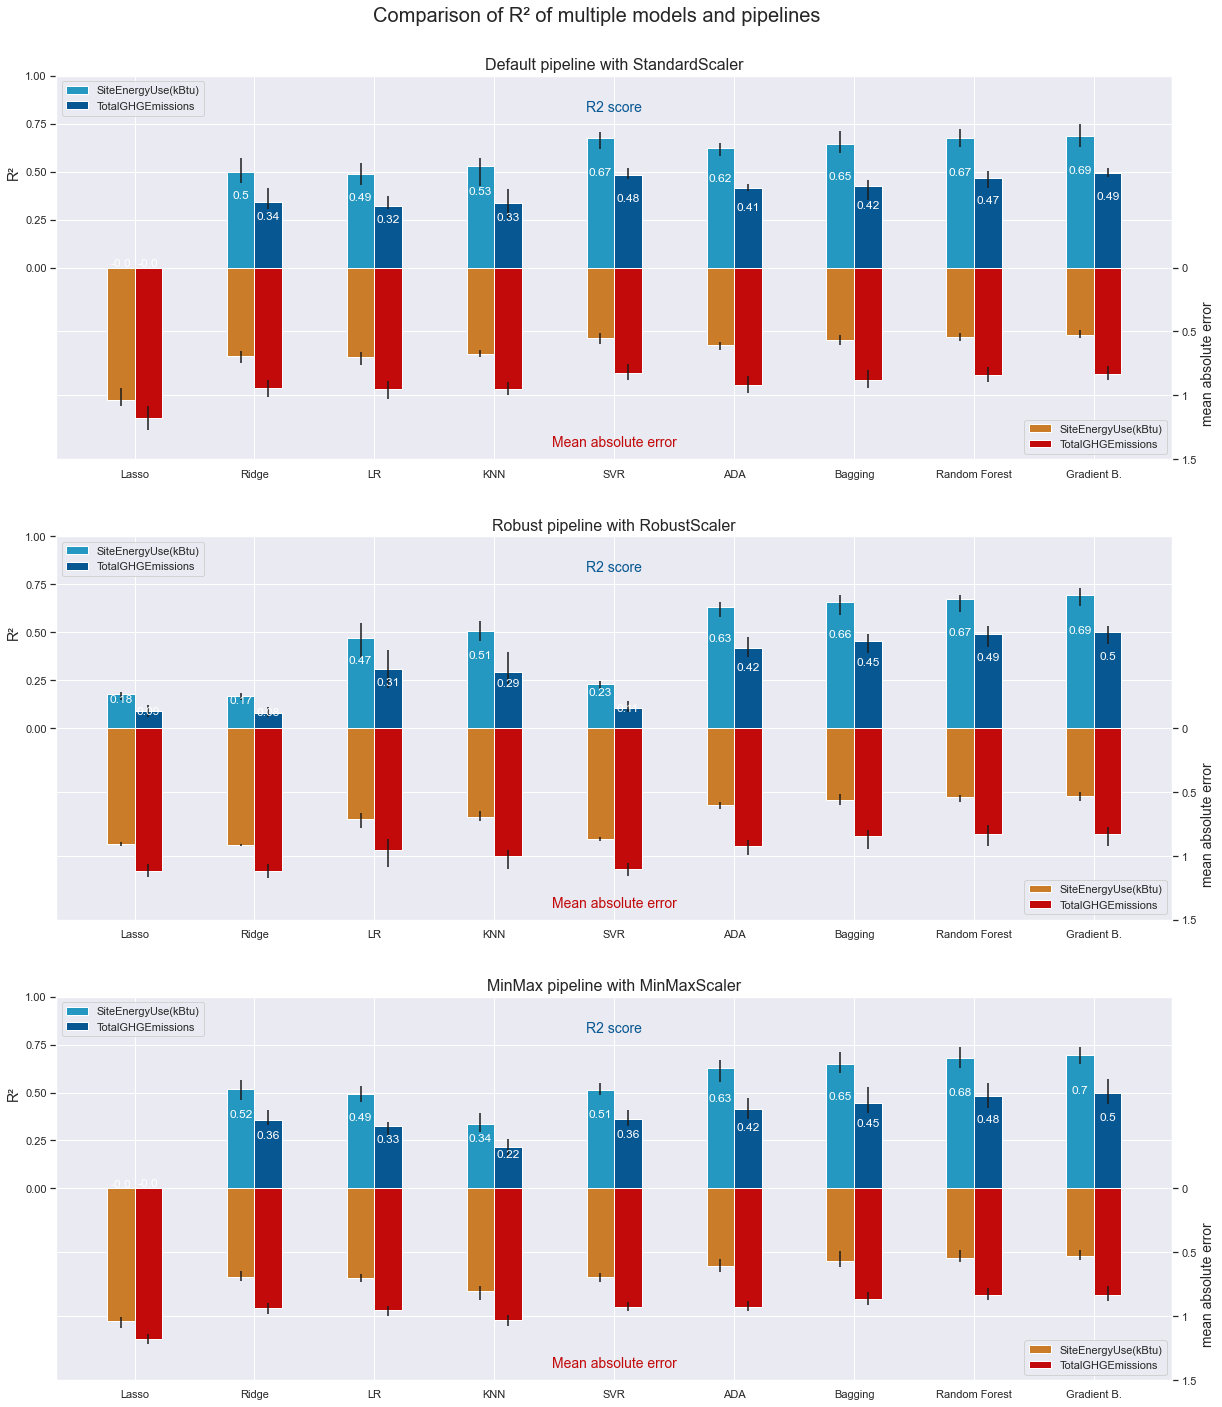

In [16]:
fig, axes = plt.subplots(figsize=(20,24), nrows=3)
fig.suptitle("Comparison of R² of multiple models and pipelines", fontsize=20, y=0.92)

# Plot 1
results = test_multiple_regressors(
    data, 
    preprocess_pipeline='default', 
    kfold_shuffle=True, 
    kfold_n_splits=5, 
    regressors=regressors
)
plot_regressors_results(results, ax=axes[0], title="Default pipeline with StandardScaler")

# Plot 2
results = test_multiple_regressors(
    data, 
    preprocess_pipeline='robust_scaling', 
    kfold_shuffle=True, 
    kfold_n_splits=5, 
    regressors=regressors
)
plot_regressors_results(results, ax=axes[1], title="Robust pipeline with RobustScaler")

# Plot 3
results = test_multiple_regressors(
    data, 
    preprocess_pipeline='minmax_scaling', 
    kfold_shuffle=True, 
    kfold_n_splits=5, 
    regressors=regressors
)
plot_regressors_results(results, ax=axes[2], title="MinMax pipeline with MinMaxScaler")

These results shows us that the **ensemble models are the best ones** because :
* They provide the best scores
* They provide the best robustness to the outliers (the scores don't vary that much between each scaler)

In the rest of this notebook, we are going to focus only on **these 4 models** : 
* ADA Boost Regressor
* Bagging Regressor
* Random Forest Regressor
* Gradient Boosting Regressor

<a name="2.2"></a>
## 2.2 Effect of cross-validation shuffle parameter on score
In the above test, we can notice that I used the parameter `shuffle = True` for the `KFold` creation for the cross-validation.
This choice is not arbitrary, and I will explain why I chose it.

First of all, lets compare our models scores with and without the `shuffle` parameter.

In [17]:
final_regressors = {
    'ADA': {
        0: AdaBoostRegressor(),
        1: AdaBoostRegressor()
    },
    'Bagging': {
        0: BaggingRegressor(),
        1: BaggingRegressor()
    },
    'R. Forest': {
        0: RandomForestRegressor(),
        1: RandomForestRegressor()
    },
    'Gradient B.': {
        0: GradientBoostingRegressor(),
        1: GradientBoostingRegressor()
    }
}

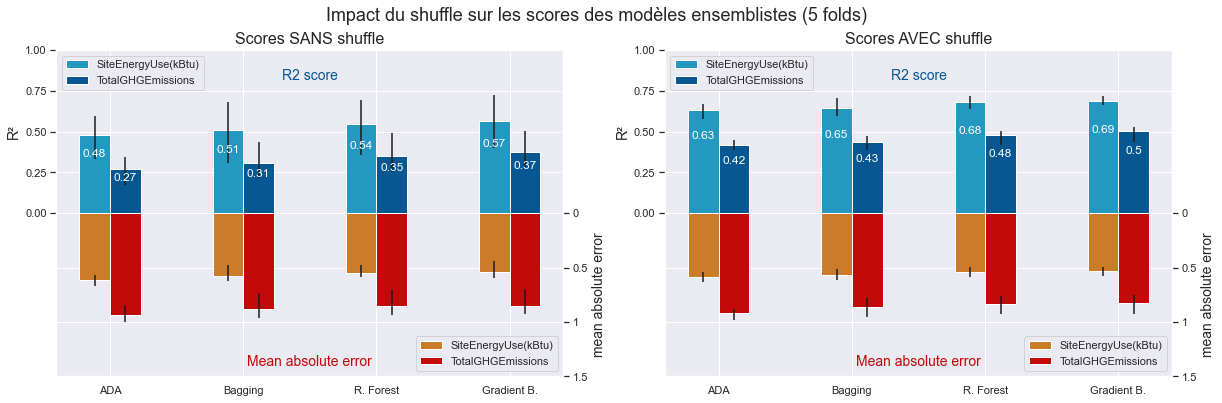

In [18]:
fig, axes = plt.subplots(figsize=(20,6), ncols=2)
fig.suptitle("Impact du shuffle sur les scores des modèles ensemblistes (5 folds)", fontsize=18)

# Results without shuffle
results = test_multiple_regressors(
    data, 
    preprocess_pipeline='default', 
    kfold_shuffle=False, 
    kfold_n_splits=5, 
    regressors=final_regressors
)
plot_regressors_results(results, ax=axes[0], title="Scores SANS shuffle")

# Plot 2
results = test_multiple_regressors(
    data, 
    preprocess_pipeline='default', 
    kfold_shuffle=True, 
    kfold_n_splits=5, 
    regressors=final_regressors
)
plot_regressors_results(results, ax=axes[1], title="Scores AVEC shuffle")

We observe 2 main thingss : 
1. Scores are **globally better** with the shuffle parameter set to True.
2. The score scattering is much better with the shuffle parameter set to True.

But how can we be sure that our score "with shuffle" are not a lucky shot, with a perfect shuffle ?
Let's run 100 cross_validation, with 5 folds for each, and plot how the mean score fluctuate.

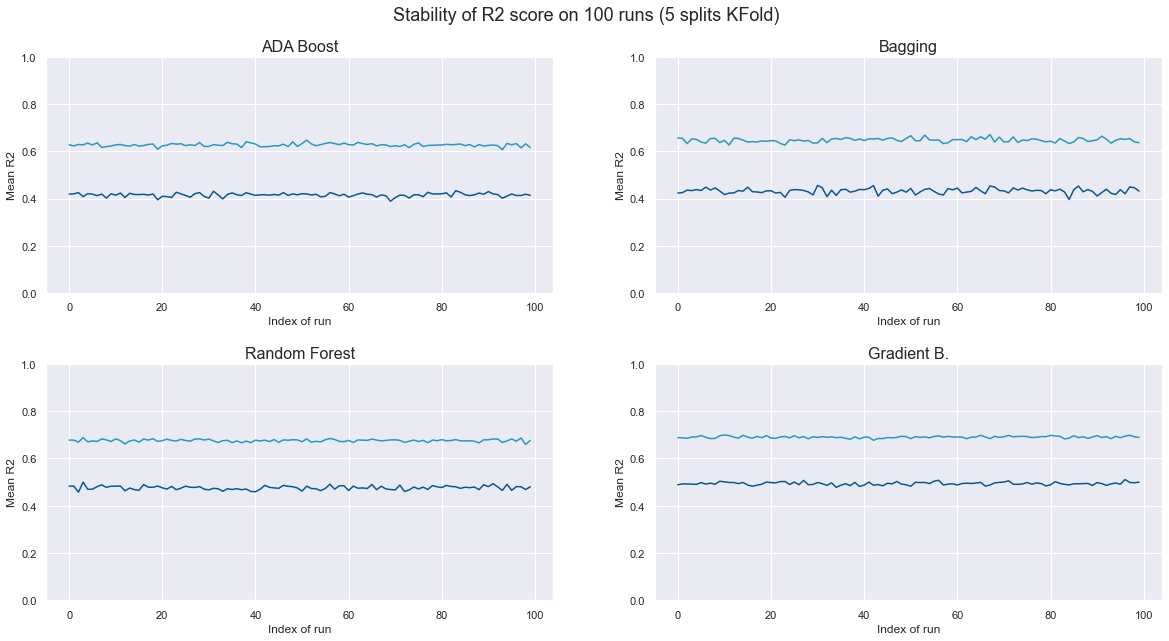

In [19]:
comp_regressors = {
    'ADA Boost': AdaBoostRegressor(),
    'Bagging': BaggingRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient B.': GradientBoostingRegressor()
}

X, y = get_modeling_data(data, preprocess_pipeline="default")

results = {}

# Defining how many times we want to run our cross-validation
TOTAL_RUNS = 100
fold_loop = range(0, TOTAL_RUNS)

for regressor_name, regressor in comp_regressors.items():
    fold_loop_means = {'0': [], '1': []}
    
    for i in fold_loop:
        r2s = {'0': [], '1': []}

        kfold = KFold(n_splits=5, shuffle=True)
        for train_index, test_index in kfold.split(X):
            X_train, X_test = X[train_index], X[test_index]

            # We have multiple targets so we have to split each run in as many sub-run as the number of targets
            for target_index in range(y.shape[1]):
                y_train, y_test = y[train_index][:,target_index], y[test_index][:,target_index]

                # Cloning and running the regressor
                regressor_clone = clone(regressor)
                regressor_clone.fit(X_train, y_train)
                y_pred = regressor_clone.predict(X_test)

                # Calculating metrics
                r2 = r2_score(y_test, y_pred)
                mse = mean_squared_error(y_test, y_pred)

                r2s[str(target_index)].append(r2)

        fold_loop_means['0'].append(np.mean(r2s['0']))
        fold_loop_means['1'].append(np.mean(r2s['1']))
    
    results[regressor_name] = fold_loop_means
        
        
# Now we can plot all the results
nrows = math.ceil(len(comp_regressors)/2)
fig, axes = plt.subplots(figsize=(20,10), ncols=2, nrows=nrows)
fig.subplots_adjust(hspace=0.3)
fig.suptitle("Stability of R2 score on " + str(TOTAL_RUNS) + " runs (5 splits KFold)", fontsize=18, y=0.95)

index = 0
for regressor_name, values in results.items():
    if nrows > 1:
        ax = axes[math.floor(index/2)][index%2]
    else:
        ax = axes[index%2]

    ax.plot(fold_loop, values['0'], color=TARGET_COLORS[0])
    ax.plot(fold_loop, values['1'], color=TARGET_COLORS[1])
    
    ax.set_ylim(0,1)
    ax.set_title(regressor_name, fontsize=16)
    ax.set_ylabel("Mean R2")
    ax.set_xlabel("Index of run")

    index += 1

We notice that, despite the `shuffle`, the mean score is very stable. So the "scores with shuffle" we obtain above are the real models scores. We can trust them.

<a name="2.3"></a>
## 2.3 Optimizing models hyperparameters
Now we know which pipeline to keep (the default one) we can try to optimize our models by searching for the best hyperparameters combination. In order to do that, we are going to follow the 2 following steps : 
1. Plot the "validation_curves" of each hyperparameter we can to improve, in order to define a value range to test,
2. Use `GridSearchCV` the pre-defined ranges in order to find out the best combination.

### 2.3.1 Validation curves

In [20]:
from sklearn.utils import shuffle

def grid_search_cv_model(work_data, model, param_grid, cv=5, preprocess_pipeline='default', test_size=0.2):
    '''
    Run a GridSearchCV for the given model with all the given params
    
    Parameters:
    :param work_data(DataFrame) : the date to work with
    :param model : the model to test
    :param param_grid(dict) : all the params to test and their possible values
    :param cv(int): the 'cv' param of the GridSearchCV method
    :param preprocess_pipeline(string) : the name of the pipeline to apply
    :param test_size(int|float) : the test_size value of the train_test_split method
    
    Returns
    :return a dict with all the results
    '''
    X, y = get_modeling_data(work_data, preprocess_pipeline=preprocess_pipeline)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=cv)

    # Running the grid search CV for each target
    results = {}
    for target_index in range(y.shape[1]):
        grid_search_results = grid_search.fit(X_train, y_train[:,target_index])
        print("Best params for target " + str(target_index) + " : " + str(grid_search_results.best_params_) + "\n")
        #print("Mean results for target " + str(target_index) + " : " + str(grid_search_results.cv_results_['mean_test_score']))
        results[target_index] = grid_search_results

    return results

def validation_curve_plot(work_data,
                          model, 
                          param_name, 
                          param_range, 
                          target_index=0, 
                          cv=5, 
                          preprocess_pipeline='robust_scaling', 
                          test_size=0.2, 
                          ax=None, 
                          plot_detail=True,
                          scoring=None,
                          shuffle=True
):
    '''
    Run a validation_curve and plot the results
    
    Parameters:
    :param work_data(DataFrame) : the date to work with
    :param model : the model to test
    :param param_name(string) : the param name of the validation curve
    :param param_range(list) : the list of values to test
    :param cv(int): the 'cv' param of the GridSearchCV method
    :param preprocess_pipeline(string) : the name of the pipeline to apply
    :param test_size(int|float) : the test_size value of the train_test_split method
    :param ax(matplotlib axe) : the ax to plot the result
    :param plot_detail(bool) : wether to plot the detail curves (each kfold)
    :param scoring(string) : the score to calculate
    :param shuffle(bool) : wether to shuffle or not the kfolds
    
    Returns
    :return nothing
    '''
    X, y = get_modeling_data(work_data, preprocess_pipeline=preprocess_pipeline)
    
    kfold = KFold(n_splits=cv, shuffle=shuffle)

    # We have multiple targets so we have to split each run in as many sub-run as the number of targets
    for target_index in range(y.shape[1]):
        train_score, val_score = validation_curve(model, 
                                                  X, 
                                                  y[:,target_index], 
                                                  param_name=param_name, 
                                                  param_range=param_range, 
                                                  cv=kfold.split(X),
                                                  scoring=scoring)
    
    # Ploting the results
    if ax == None:
        fig = plt.figure(figsize=(15,10))
        ax = plt.gca()
        
    # Plotting mean scores
    ax.plot(param_range, val_score.mean(axis=1), color=TARGET_COLORS[target_index], linewidth="2", label='Validation')
    ax.plot(param_range, train_score.mean(axis=1), color='grey', linewidth="2", label='Train')

    # If asked, plotting all CV scores
    if plot_detail:
        for serie in val_score.T:
            ax.plot(param_range, serie, color=TARGET_COLORS[target_index], linestyle='--', linewidth="0.5", label=None)
        for serie in train_score.T:
            ax.plot(param_range, serie, color='grey', linestyle='--', linewidth="0.5", label=None)

    ax.set_ylabel('Score')
    #ax.set_ylim(None,1)
    ax.set_xlabel(param_name)
    ax.legend()
    
def plot_params_validation_curves(work_data, model, params, preprocess_pipeline='default'):
    '''
    Run all the validation curves and plot them all in a single figure
    
    Parameters:
    :param work_data(DataFrame) : the date to work with
    :param model : the model to test
    :param params(dict) : all the params to test and their list of values
    :param preprocess_pipeline(string) : the name of the pipeline to apply
    
    Returns
    :return nothing
    '''
    fig, axes = plt.subplots(figsize=(15,5*len(params)), ncols=len(targets), nrows=len(params))
    for target_index in range(len(targets)):
        if len(params) > 1:
            ax = axes[0][target_index]
        else:
            ax = axes[target_index]
            
        ax.set_title(targets[target_index], fontsize=16)
        
        param_index = 0
        for param_name, param_range in params.items():
            if len(params) > 1:
                ax = axes[param_index][target_index]
            else:
                ax = axes[target_index]

            validation_curve_plot(work_data,
                                  model, 
                                  target_index=target_index, 
                                  param_name=param_name, 
                                  param_range=param_range, 
                                  ax=ax,
                                  preprocess_pipeline=preprocess_pipeline)
            param_index+=1

#### Ada Boost

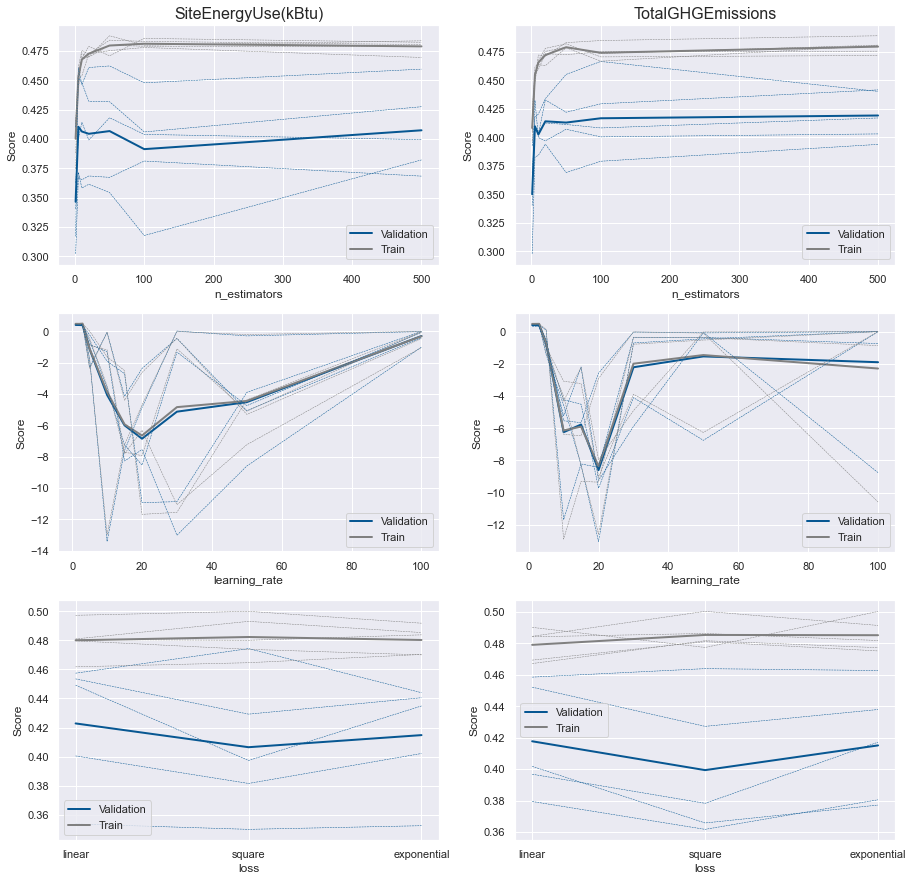

In [21]:
params = {
    'n_estimators': [1,5,10,20,50,100,500],
    'learning_rate': [1,2,3,5,10,15,20,30,50,100],
    'loss': ['linear', 'square', 'exponential']
}

plot_params_validation_curves(data, AdaBoostRegressor(), params)

#### Bagging

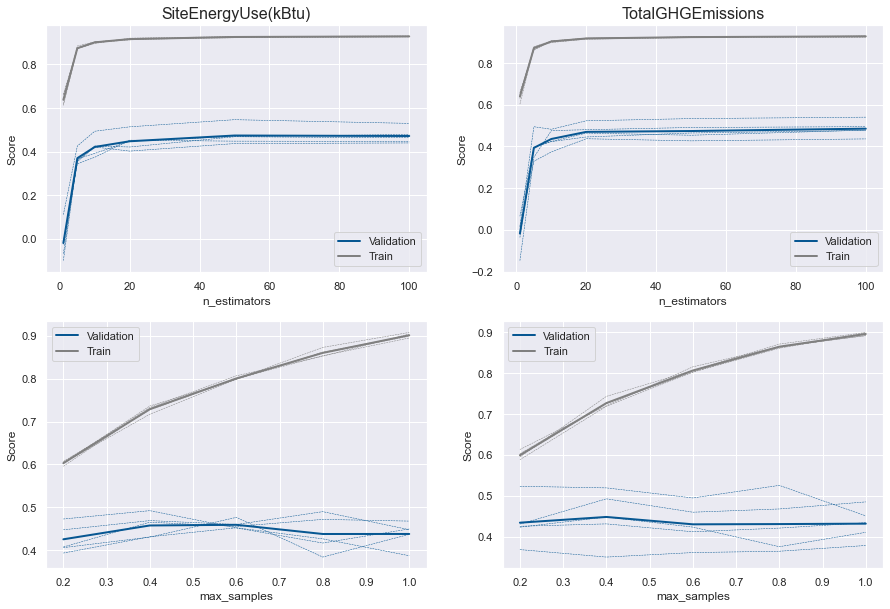

In [22]:
params = {
    'n_estimators': [1,5,10,20,50,100],
    'max_samples': np.arange(0.2,1.1,0.2)
}

plot_params_validation_curves(data, BaggingRegressor(), params, preprocess_pipeline="default")

#### Random Forest

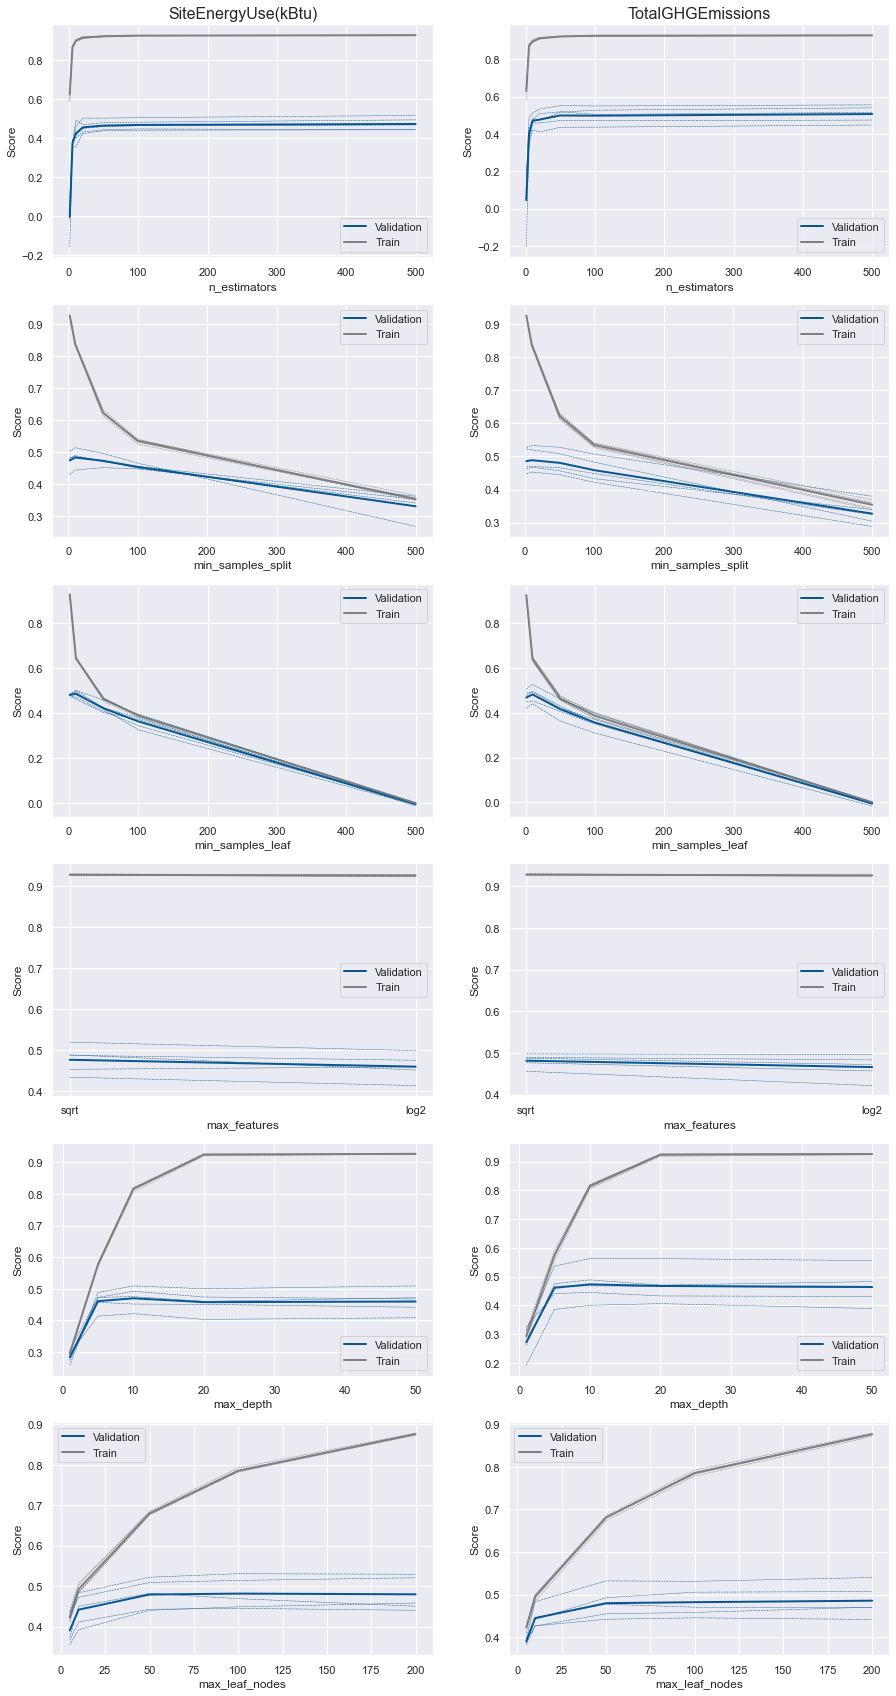

In [23]:
params = {
    'n_estimators': [1,5,10,20,50,100,500],
    'min_samples_split': [2,10,50,100,500],
    'min_samples_leaf': [1,10,50,100,500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [1,5,10,20,50,None],
    'max_leaf_nodes': [5,10,50,100,200,None]
}

plot_params_validation_curves(data, RandomForestRegressor(), params)

#### Gradient Boosting

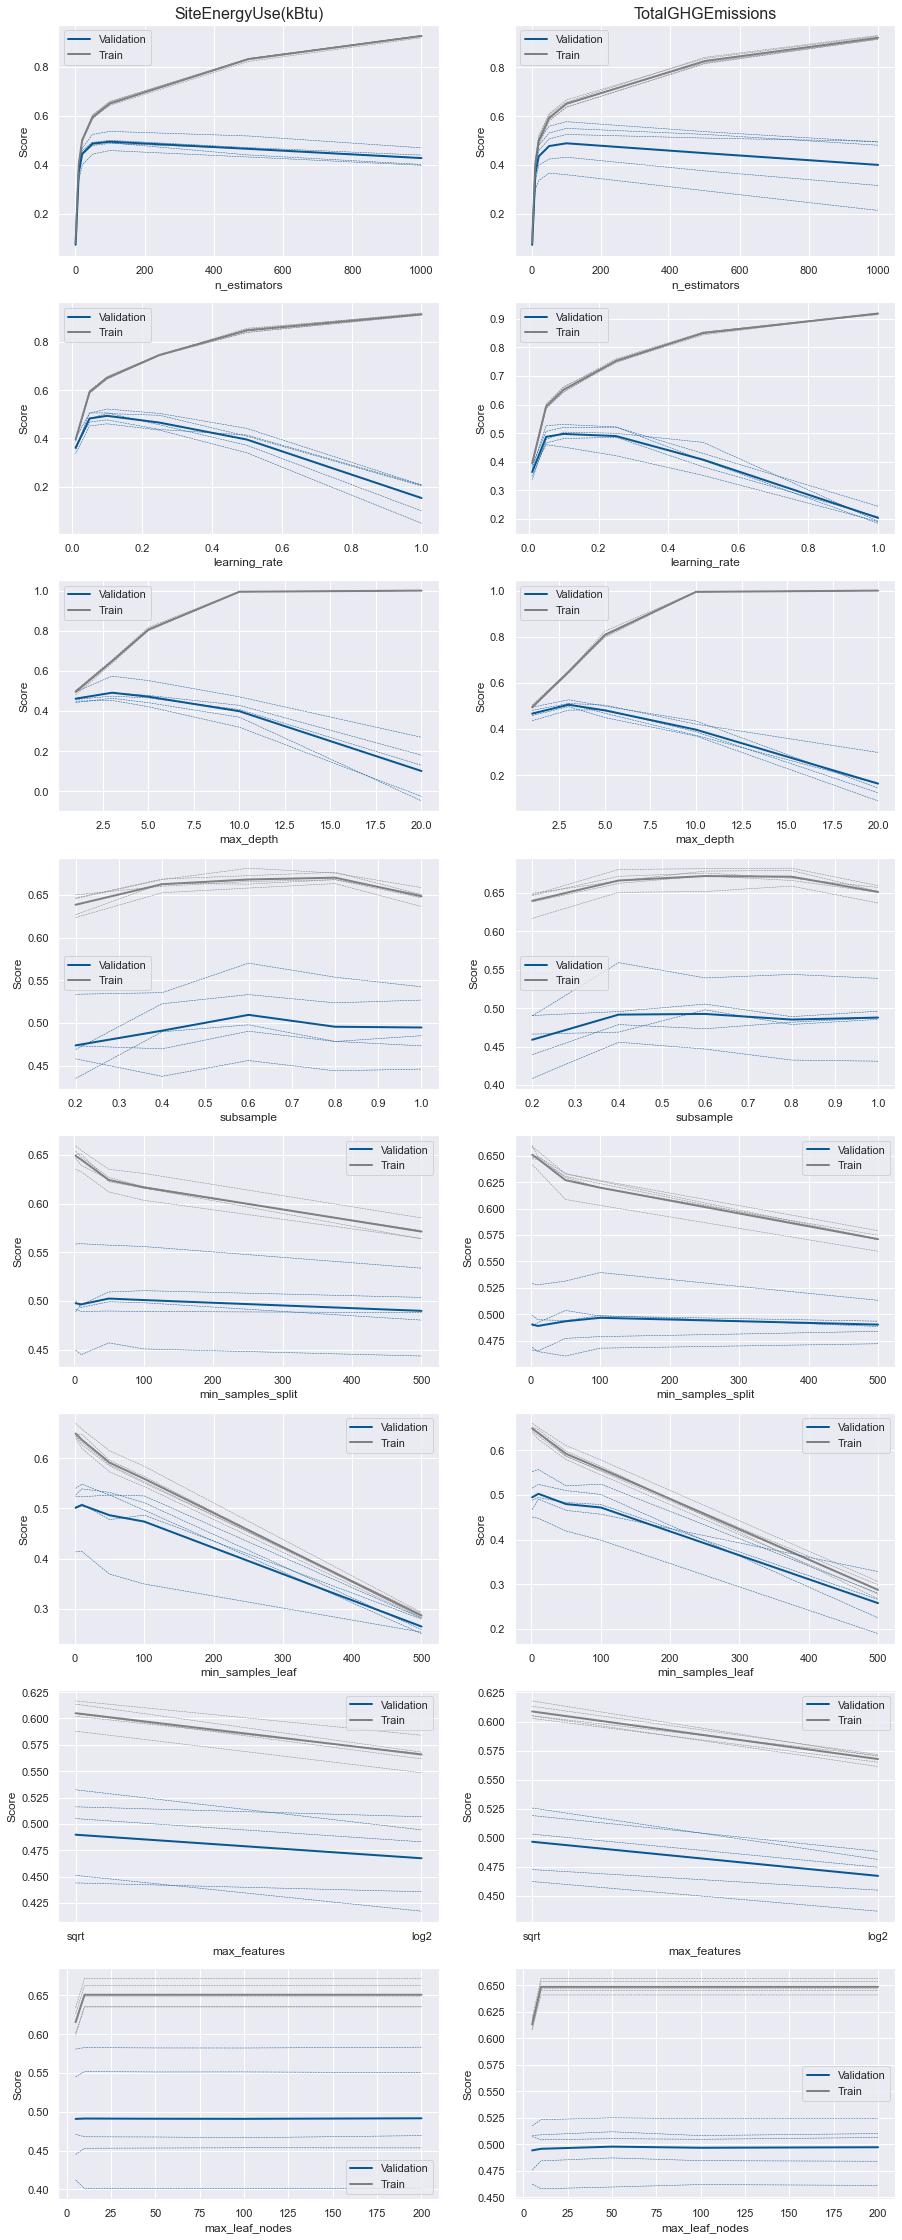

In [24]:
params = {
    'n_estimators': [1,10,20,50,100,500,1000],
    'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01],
    'max_depth': [1,3,5,10,20],
    'subsample': np.arange(0.2,1.2,0.2),
    'min_samples_split': [2,10,50,100,500],
    'min_samples_leaf': [1,10,50,100,500],
    'max_features': ['sqrt', 'log2'],
    'max_leaf_nodes': [5,10,50,100,200,None]
}

plot_params_validation_curves(data, GradientBoostingRegressor(), params)

<a name="2.3.2"></a>
### 2.3.2 GridSearchCV

In [25]:
best_estimators = {}

#### Ada Boost Regressor

In [26]:
gridsearch_results = grid_search_cv_model(data, AdaBoostRegressor(), param_grid={
    'n_estimators': [1,5,10,20,50],
    'learning_rate': [1,20,50,100],
    'loss': ['linear', 'square', 'exponential']
})

best_estimators['Ada Boost'] = {}
for target_index, gridsearch in gridsearch_results.items():
    best_estimators['Ada Boost'][target_index] = gridsearch.best_estimator_

Best params for target 0 : {'learning_rate': 1, 'loss': 'square', 'n_estimators': 50}

Best params for target 1 : {'learning_rate': 1, 'loss': 'exponential', 'n_estimators': 50}



#### Bagging Regressor

In [27]:
gridsearch_results = grid_search_cv_model(data, BaggingRegressor(), param_grid={
    'n_estimators': [1, 20, 50, 100],
    'max_samples': [0.2, 0.5, 0.8, 1.0]
})

best_estimators['Bagging'] = {}
for target_index, gridsearch in gridsearch_results.items():
    best_estimators['Bagging'][target_index] = gridsearch.best_estimator_

Best params for target 0 : {'max_samples': 0.5, 'n_estimators': 100}

Best params for target 1 : {'max_samples': 0.5, 'n_estimators': 50}



#### Random Forest Regressor

In [28]:
gridsearch_results = grid_search_cv_model(data, RandomForestRegressor(), param_grid={
    'n_estimators': [1,20,50,100],
    'min_samples_split': [2,50,100],
    'min_samples_leaf': [1,50,100],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [1,10,50,None],
    'max_leaf_nodes': [5,50,100,None]
})

best_estimators['Random Forest'] = {}
for target_index, gridsearch in gridsearch_results.items():
    best_estimators['Random Forest'][target_index] = gridsearch.best_estimator_

Best params for target 0 : {'max_depth': 50, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Best params for target 1 : {'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}



#### Gradient Boosting Regressor

For the Gradient Boosting Regressor, in order to reduce the number of tested combinations (because the total run time could be greater than 60 hours !) we are going to follow the hypothesis below :
* `min_sample_leaf` should be minimum (1) because its validation_curve is strictly decreasing,
* `max_features` has no major effect so we keep the default value,
* `max_leaf_nodes` has no effect either, so we keep the default value for it.

In [29]:
gridsearch_results = grid_search_cv_model(data, GradientBoostingRegressor(), param_grid={
    'n_estimators': [10,50,100,200],
    'learning_rate': [0.5, 0.2, 0.1, 0.05, 0.02, 0.01],
    'max_depth': [1,3,5,10],
    'subsample': [0.2, 0.6, 1.0],
    'min_samples_split': [2, 0.2, 0.5, 0.8, 1.0]
})

best_estimators['Gradient Boosting'] = {}
for target_index, gridsearch in gridsearch_results.items():
    best_estimators['Gradient Boosting'][target_index] = gridsearch.best_estimator_

Best params for target 0 : {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 0.8, 'n_estimators': 200, 'subsample': 1.0}

Best params for target 1 : {'learning_rate': 0.2, 'max_depth': 10, 'min_samples_split': 0.8, 'n_estimators': 50, 'subsample': 1.0}



<a name="2.3.3"></a>
### 2.3.3 Measuring impact of optimization

In [30]:
best_estimators
best_estimators_save = best_estimators

In [31]:
basic_regressors = {
    'Ada Boost': {0: AdaBoostRegressor(), 1: AdaBoostRegressor()},
    'Bagging': {0: BaggingRegressor(), 1: BaggingRegressor()},
    'Random Forest': {0: RandomForestRegressor(), 1: RandomForestRegressor()},
    'Gradient Boosting': {0: GradientBoostingRegressor(), 1: GradientBoostingRegressor()}
}

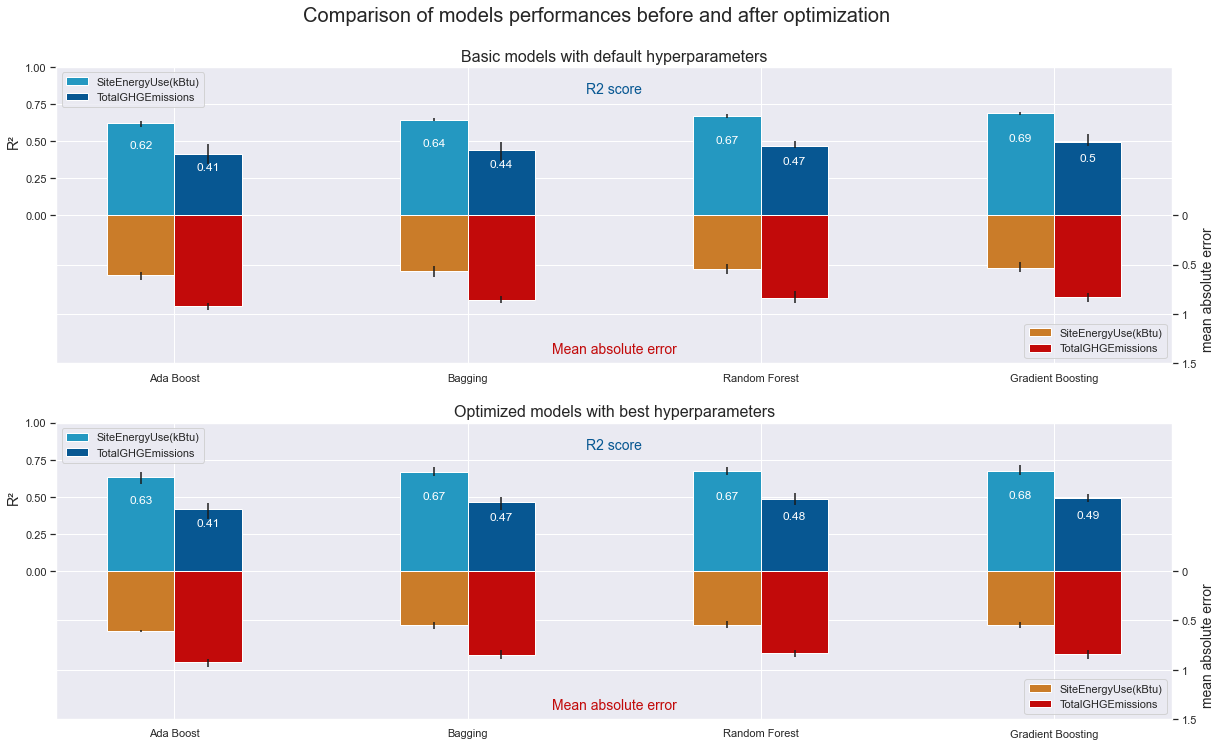

In [32]:
fig, axes = plt.subplots(figsize=(20,12), nrows=2)
fig.suptitle("Comparison of models performances before and after optimization", fontsize=20, y=0.95)

# Plot 1
results = test_multiple_regressors(
    data, 
    preprocess_pipeline='default', 
    kfold_shuffle=True, 
    kfold_n_splits=5, 
    regressors=basic_regressors
)
plot_regressors_results(results, ax=axes[0], title="Basic models with default hyperparameters")

# Plot 2
results = test_multiple_regressors(
    data, 
    preprocess_pipeline='default', 
    kfold_shuffle=True, 
    kfold_n_splits=5, 
    regressors=best_estimators
)
plot_regressors_results(results, ax=axes[1], title="Optimized models with best hyperparameters")

<a name="2.4"></a>
## 2.4 Impact of EnergyStar Score on models 
In order to measure the impact of the EnergyStar Score (ESS) on our models, we re-run the models keeping this column with a new pipeline.

The comparison above shows us that the ESS can be very useful be cause it allows to **improve our R² scores by 0.05** for almost all models (except for Ada Boost).

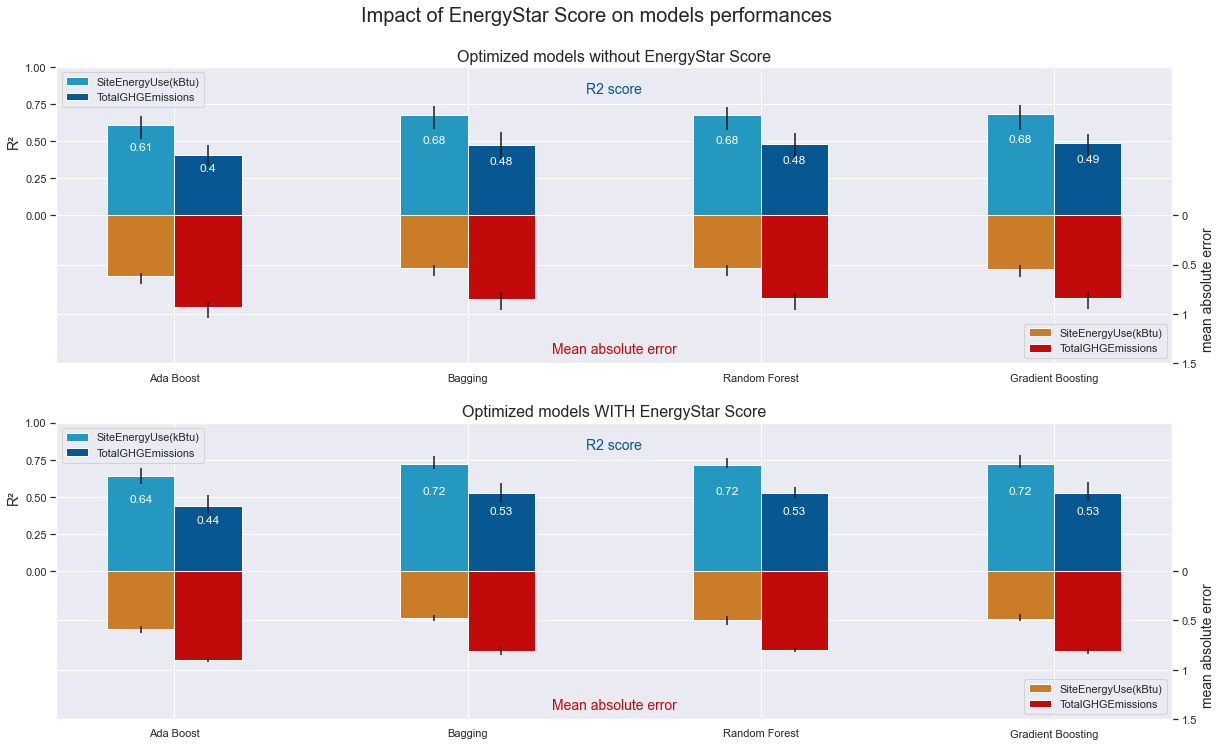

In [33]:
fig, axes = plt.subplots(figsize=(20,12), nrows=2)
fig.suptitle("Impact of EnergyStar Score on models performances", fontsize=20, y=0.95)

# Plot 1
results = test_multiple_regressors(
    data, 
    preprocess_pipeline='default', 
    kfold_shuffle=True, 
    kfold_n_splits=5, 
    regressors=best_estimators
)
plot_regressors_results(results, ax=axes[0], title="Optimized models without EnergyStar Score")

# Plot 2
results = test_multiple_regressors(
    data, 
    preprocess_pipeline='default_with_ess', 
    kfold_shuffle=True, 
    kfold_n_splits=5, 
    regressors=best_estimators
)
plot_regressors_results(results, ax=axes[1], title="Optimized models WITH EnergyStar Score")

<a name="3"></a>
# 3. Exploring our final model
The comparison above pushed us into choosing the **Gradient Boosting Regressor model** because it's the on with the highest scores, with and without the energy star score.

We are now going to test its performances with more details than before.

<a name="3.1"></a>
## 3.1 Features importances

In [13]:
def get_output_features_input_names(feature_pipeline):
    '''
    Returns the output feature names of a given pipeline 
    
    Parameters:
    :param feature_pipeline(Pipeline): the pipeline object
    
    Returns:
    :return the list of output features names
    '''
    # the [:] is here to avoid te reference between both arrays
    output_features = scaling_features[:]
    encoding_output_names = feature_pipeline.steps[0][1].transformers_[1][1].get_feature_names(encoding_features)
    
    # Splitting using underscore allows us to separate input name and output name (we keep input name only)
    for encoding_output_name in encoding_output_names:
        parts = encoding_output_name.split('_')
        output_features.append(parts[0])
        
    return output_features

In [35]:
final_models = {
    0: GradientBoostingRegressor(learning_rate=0.02, max_depth=5, min_samples_split=2, n_estimators=200, subsample=0.6),
    1: GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_split=2, n_estimators=100, subsample=0.6)
}

# We are going to run the pipeline manually to be able to retrieve the initial features names
X,y = get_modeling_data(data, preprocess_pipeline=None)

pipeline_name = 'default'
pipeline_features = PREPROCESS_PIPELINES[pipeline_name]['features']
pipeline_targets = PREPROCESS_PIPELINES[pipeline_name]['targets']

X_trans = pipeline_features.fit_transform(X)
y_trans = pipeline_targets.fit_transform(y)

final_models[0].fit(X_trans, y_trans[:,0])
final_models[1].fit(X_trans, y_trans[:,1])

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, subsample=0.6)

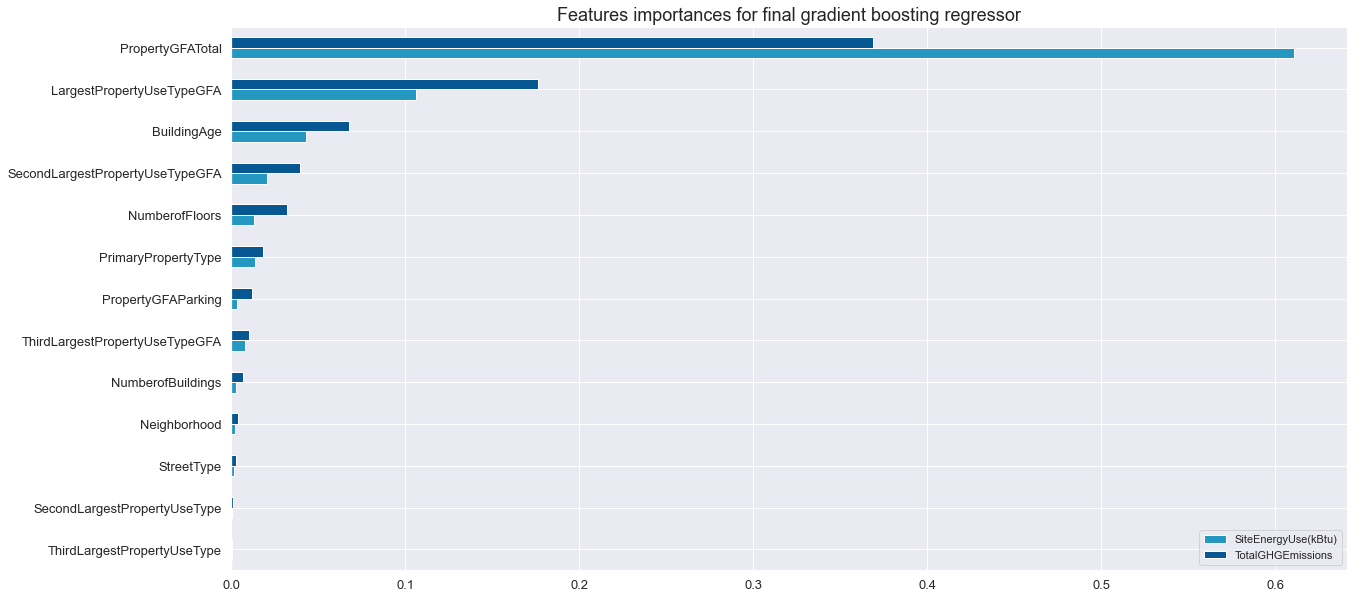

In [36]:
features_importances = pd.DataFrame([
    get_output_features_input_names(pipeline_features), 
    final_models[0].feature_importances_, 
    final_models[1].feature_importances_
]).T
features_importances.columns = ['feature', targets[0], targets[1]]
for target_index in range(len(targets)):
    features_importances[targets[target_index]] = pd.to_numeric(features_importances[targets[target_index]], downcast="float")

features_importances = features_importances\
    .set_index('feature')\
    .sort_index()\
    .groupby('feature').mean()\
    .sort_values(by=targets[1], ascending=True)

features_importances.plot(kind='barh', figsize=(20,10), color=TARGET_COLORS, fontsize=13, xlabel="")
plt.title("Features importances for final gradient boosting regressor", fontsize=18)
plt.legend(loc="lower right")

<a name="3.2"></a>
## 3.2 Metrics

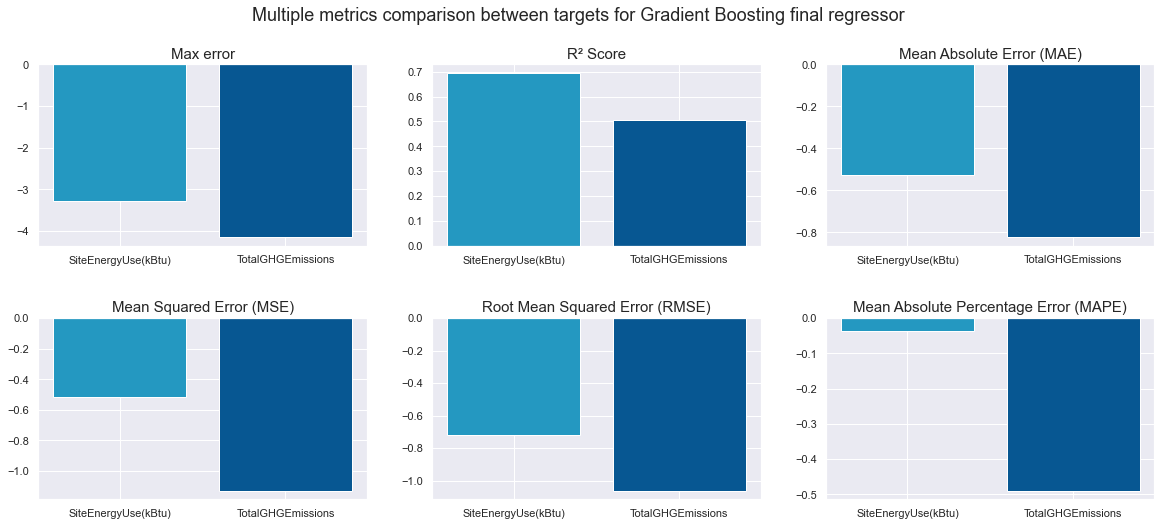

In [37]:
metrics = [
    'max_error',
    'r2',
    'neg_mean_absolute_error',
    'neg_mean_squared_error',
    'neg_root_mean_squared_error',
    'neg_mean_absolute_percentage_error',
]
names = [
    'Max error',
    'R² Score',
    'Mean Absolute Error (MAE)',
    'Mean Squared Error (MSE)',
    'Root Mean Squared Error (RMSE)',
    'Mean Absolute Percentage Error (MAPE)'
]

scores = {}

# Manually managing the Kfold to be able to shuffle them in the cross_validate function
kfolds = KFold(n_splits=5, shuffle=True)
for target_index, model in final_models.items():
    scores[target_index] = cross_validate(model, X_trans, y_trans[:,target_index], cv=kfold.split(X_trans), scoring=metrics)
    
fig, axes = plt.subplots(figsize=(20,4*math.ceil(len(metrics)/3)), nrows=math.ceil(len(metrics)/3), ncols=3)
fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle("Multiple metrics comparison between targets for Gradient Boosting final regressor", fontsize=18)

i = 0
for metric in metrics:
    score_name = "test_" + str(metric)
    axes[math.floor(i/3)][i % 3].bar(x=range(len(targets)), 
                                     height=[np.mean(scores[0][score_name]), np.mean(scores[1][score_name])],
                                     color=TARGET_COLORS)
    axes[math.floor(i/3)][i % 3].set_title(names[i], fontsize=15)
    axes[math.floor(i/3)][i % 3].set_xticks([0,1])
    axes[math.floor(i/3)][i % 3].set_xticklabels(targets)
    i += 1

<a name="3.3"></a>
## 3.3 Real values VS predicted values

In [38]:
final_models = {
    0: GradientBoostingRegressor(learning_rate=0.02, max_depth=5, min_samples_split=2, n_estimators=200, subsample=0.6),
    1: GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_split=2, n_estimators=100, subsample=0.6)
}

# We are going to run the pipeline manually to be able to retrieve the initial features names
shuffle_data = shuffle(data)
X,y = get_modeling_data(data, preprocess_pipeline=None)

pipeline_name = 'default'
pipeline_features = PREPROCESS_PIPELINES[pipeline_name]['features']
pipeline_targets = PREPROCESS_PIPELINES[pipeline_name]['targets']

X_trans = pipeline_features.fit_transform(X)
y_trans = pipeline_targets.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_trans, y_trans, test_size=0.2)


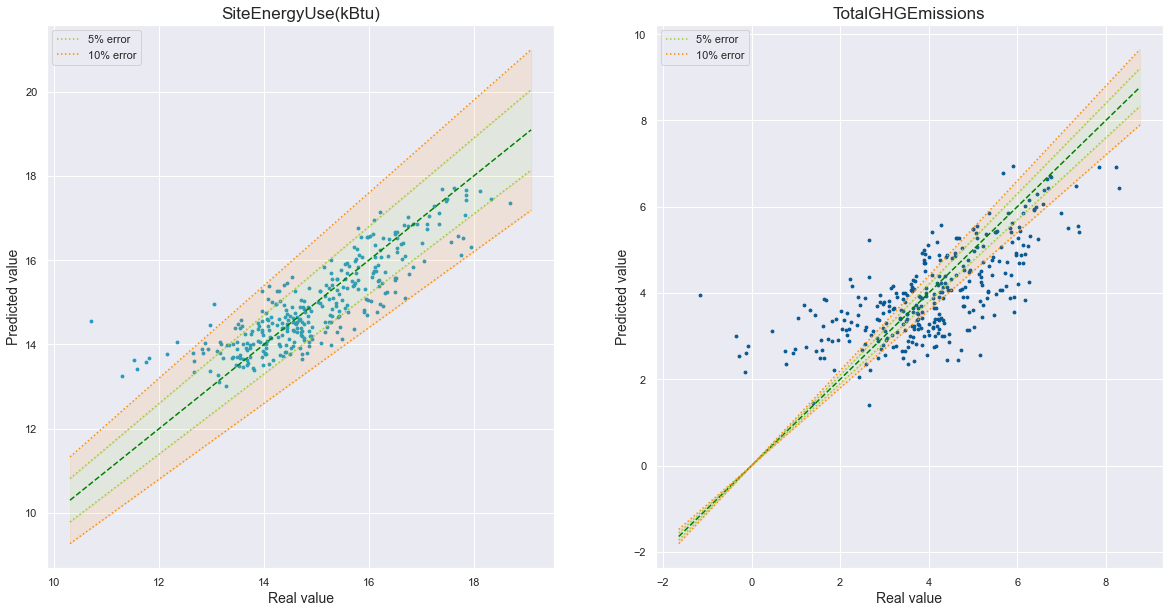

In [39]:
fig, axes = plt.subplots(figsize=(20,10), ncols=2)

for target_index in range(len(targets)):
    final_models[target_index].fit(X_train, y_train[:,target_index])
    y_pred = final_models[target_index].predict(X_test)
    
    axes[target_index].scatter(x=y_test[:,target_index], y=y_pred, color=TARGET_COLORS[target_index], s=8)
    axes[target_index].set_title(targets[target_index], fontsize=17)
    axes[target_index].set_xlabel('Real value', fontsize=14)
    axes[target_index].set_ylabel('Predicted value', fontsize=14)
    
    # Ploting 45° line
    x = np.linspace(*axes[target_index].get_xlim())
    axes[target_index].plot(x, x, color='green', linestyle='--')
    
    # Ploting and filling the -5% +5% interval
    axes[target_index].plot(x, x*0.95, color='yellowgreen', linestyle='dotted', label="5% error")
    axes[target_index].plot(x, x*1.05, color='yellowgreen', linestyle='dotted')
    axes[target_index].fill_between(x, x*0.95, x*1.05, color='yellowgreen', alpha=0.1)
    
    # Ploting and filling the -10% +10% interval
    axes[target_index].plot(x, x*0.9, color='darkorange', linestyle='dotted', label="10% error")
    axes[target_index].plot(x, x*1.1, color='darkorange', linestyle='dotted')
    axes[target_index].fill_between(x, x*0.9, x*0.95, color='darkorange', alpha=0.1)
    axes[target_index].fill_between(x, x*1.05, x*1.1, color='darkorange', alpha=0.1)
    
    axes[target_index].legend(loc='upper left')

## 3.4 Testing model with base targets
We know that the Gradient Boosting models are not sensitive to non-normal
targets. Is it true ?
We are going to test our final model with the base target.

In [18]:
final_models = {
    0: GradientBoostingRegressor(learning_rate=0.02, max_depth=5, min_samples_split=2, n_estimators=200, subsample=0.6),
    1: GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_split=2, n_estimators=100, subsample=0.6)
}

# We are going to run the pipeline manually to be able to retrieve the initial features names
X,y = get_modeling_data(data, preprocess_pipeline=None)

pipeline_name = 'default_no_log'
pipeline_features = PREPROCESS_PIPELINES[pipeline_name]['features']
pipeline_targets = PREPROCESS_PIPELINES[pipeline_name]['targets']

X_trans = pipeline_features.fit_transform(X)
y_trans = pipeline_targets.fit_transform(y)

final_models[0].fit(X_trans, y_trans[:,0])
final_models[1].fit(X_trans, y_trans[:,1])

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, subsample=0.6)

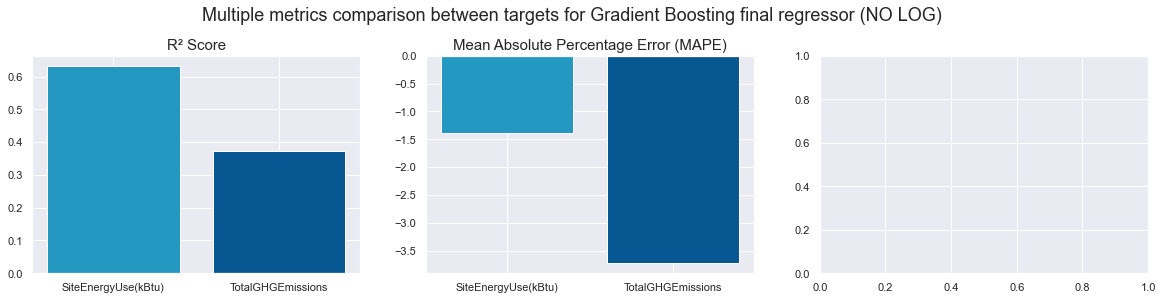

In [25]:
metrics = [
    'r2',
    'neg_mean_absolute_percentage_error',
]
names = [
    'R² Score',
    'Mean Absolute Percentage Error (MAPE)'
]

scores = {}

# Manually managing the Kfold to be able to shuffle them in the cross_validate function
kfolds = KFold(n_splits=5, shuffle=True)
for target_index, model in final_models.items():
    scores[target_index] = cross_validate(model, X_trans, y_trans[:,target_index], cv=kfolds.split(X_trans), scoring=metrics)
    
nrows = math.ceil(len(metrics)/3)
fig, axes = plt.subplots(figsize=(20,4*math.ceil(len(metrics)/3)), nrows=nrows, ncols=3)
fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle("Multiple metrics comparison between targets for Gradient Boosting final regressor (NO LOG)", fontsize=18, y=1.05)

i = 0
for metric in metrics:
    score_name = "test_" + str(metric)
    
    if nrows > 1:
        ax = axes[math.floor(i/3)][i % 3]
    else:
        ax = axes[i % 3]
    
    ax.bar(x=range(len(targets)), 
                                     height=[np.mean(scores[0][score_name]), np.mean(scores[1][score_name])],
                                     color=TARGET_COLORS)
    ax.set_title(names[i], fontsize=15)
    ax.set_xticks([0,1])
    ax.set_xticklabels(targets)
    i += 1